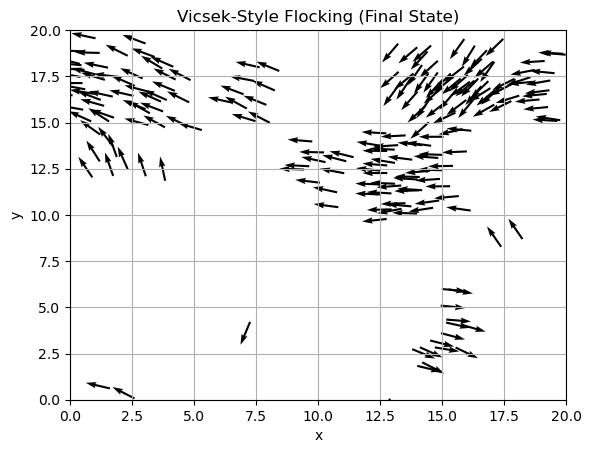

In [20]:
#basic bacteria flocking model

import numpy as np
import matplotlib.pyplot as plt
import random

# -- Parameters --
N = 200             # Number of particles
L = 20.0             # Size of the square domain
r = 1.0              # Interaction radius
eta = 0.3            # Noise level 
speed = 0.03         # Constant speed of each particle
time_steps = 300     # Number of simulation steps

#  random positions and headings
positions = np.random.rand(N, 2) * L
headings = np.random.rand(N) * 2.0 * np.pi  # random heading in [0, 2π)

#  enforce periodic boundary
def apply_periodic_boundary(pos):
    # Wrap around if outside [0, L)
    return np.mod(pos, L)

# Main  loop
for t in range(time_steps):
    new_headings = np.zeros(N)
    
    # For each particle, find neighbors and compute average direction
    for i in range(N):
        # Distance from particle i to all others (periodic boundary)
        dx = positions[:, 0] - positions[i, 0]
        dy = positions[:, 1] - positions[i, 1]
        
        # Enforce periodic distance
        dx = dx - L * np.round(dx / L)
        dy = dy - L * np.round(dy / L)
        
        dist = np.sqrt(dx*dx + dy*dy)
        
        # Neighbors are those within radius r (including the particle itself)
        neighbors = (dist < r)
        
        # Compute average heading among neighbors

        avg_vx = np.mean(np.cos(headings[neighbors]))
        avg_vy = np.mean(np.sin(headings[neighbors]))
        
        avg_angle = np.arctan2(avg_vy, avg_vx)
        
        # Add random perturbation in [-eta/2, +eta/2]
        perturbation = (random.random() - 0.5) * eta
        new_headings[i] = avg_angle + perturbation

    # Update headings
    headings = new_headings
    
    # Update positions
    vx = speed * np.cos(headings)
    vy = speed * np.sin(headings)
    positions[:, 0] += vx
    positions[:, 1] += vy
    
    # Enforce periodic boundaries
    positions = apply_periodic_boundary(positions)

# Plot the final positions and velocities
plt.quiver(positions[:, 0],
           positions[:, 1],
           np.cos(headings),
           np.sin(headings),
           scale=20)  # Arrows for direction; scale adjusts arrow length visually
plt.xlim(0, L)
plt.ylim(0, L)
plt.title("Vicsek-Style Flocking (Final State)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


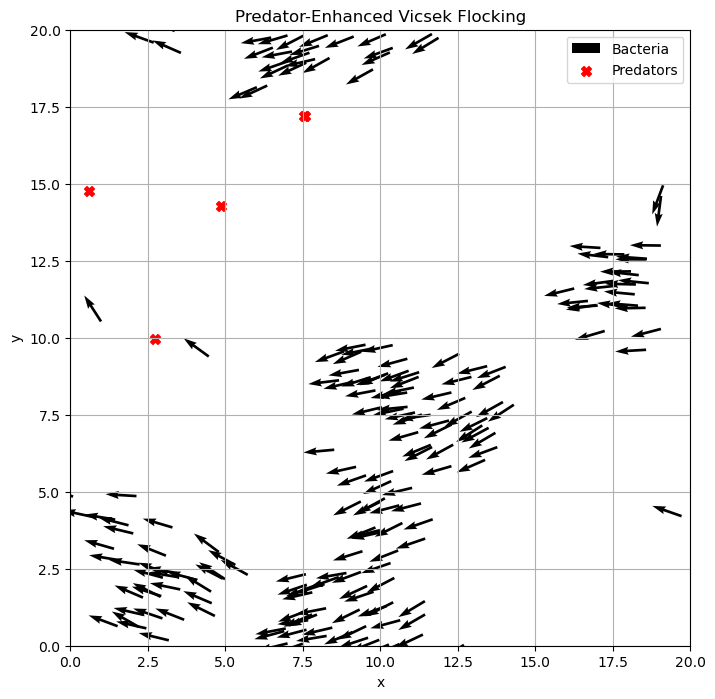

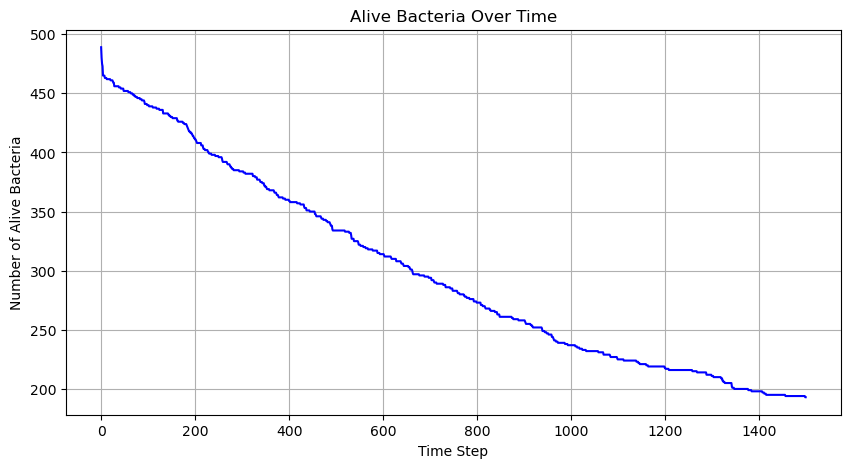

In [21]:

##modified above to add a predator model


import numpy as np
import matplotlib.pyplot as plt
import random


# -- Parameters --
N = 500             # Number of bacteria
L = 20.0             # Domain size
r = 1.0              # Interaction radius for bacteria
eta = 0.3            # Noise level
speed = 0.03         # Bacteria speed
time_steps = 300     # Simulation steps
alive_counts = []  #alive bacteria


# Predator parameters
P = 5                # Number of predators (e.g., white blood cells)
pred_speed = 0.05    # Predator speed
capture_radius = 1.5 # Radius within which bacteria are "eaten"

# Initialize bacteria
positions = np.random.rand(N, 2) * L
headings = np.random.rand(N) * 2.0 * np.pi
alive = np.ones(N, dtype=bool)  # Tracks which bacteria are alive

# Initialize predators
pred_positions = np.random.rand(P, 2) * L

# -- Helper: periodic boundary --
def apply_periodic_boundary(pos):
    return np.mod(pos, L)

# -- Main simulation loop --
for t in range(time_steps):
    new_headings = np.zeros(N)

    # Bacteria behavior
    for i in range(N):
        if not alive[i]:
            continue  # Skip dead bacteria

        # Distance from particle i to all others (periodic boundary)
        dx = positions[:, 0] - positions[i, 0]
        dy = positions[:, 1] - positions[i, 1]

        dx = dx - L * np.round(dx / L)
        dy = dy - L * np.round(dy / L)
        dist = np.sqrt(dx*dx + dy*dy)

        neighbors = (dist < r) & alive
        avg_vx = np.mean(np.cos(headings[neighbors]))
        avg_vy = np.mean(np.sin(headings[neighbors]))
        avg_angle = np.arctan2(avg_vy, avg_vx)
        perturbation = (random.random() - 0.5) * eta
        new_headings[i] = avg_angle + perturbation

    # Update bacteria headings and positions
    headings = new_headings
    vx = speed * np.cos(headings)
    vy = speed * np.sin(headings)
    positions[:, 0] += vx
    positions[:, 1] += vy
    positions = apply_periodic_boundary(positions)

    # Predator behavior
    for j in range(P):
        dx = positions[:, 0] - pred_positions[j, 0]
        dy = positions[:, 1] - pred_positions[j, 1]
        dx = dx - L * np.round(dx / L)
        dy = dy - L * np.round(dy / L)
        dist = np.sqrt(dx*dx + dy*dy)

        nearby_bacteria = (dist < 3*r) & alive
        if np.any(nearby_bacteria):
            com_x = np.mean(positions[nearby_bacteria, 0])
            com_y = np.mean(positions[nearby_bacteria, 1])
            direction = np.array([com_x, com_y]) - pred_positions[j]
            direction = direction - L * np.round(direction / L)  # Apply periodic
            norm = np.linalg.norm(direction)
            if norm > 0:
                direction /= norm
        else:
            direction = np.random.rand(2) - 0.5
            direction /= np.linalg.norm(direction)

        pred_positions[j] += pred_speed * direction
        pred_positions[j] = apply_periodic_boundary(pred_positions[j])

        # Eliminate bacteria within capture radius
        capture_dx = positions[:, 0] - pred_positions[j, 0]
        capture_dy = positions[:, 1] - pred_positions[j, 1]
        capture_dx = capture_dx - L * np.round(capture_dx / L)
        capture_dy = capture_dy - L * np.round(capture_dy / L)
        capture_dist = np.sqrt(capture_dx**2 + capture_dy**2)

        eaten = (capture_dist < capture_radius)
        alive[eaten] = False
        alive_counts.append(np.sum(alive))  


# Plot final state
plt.figure(figsize=(8, 8))
plt.quiver(positions[alive, 0],
           positions[alive, 1],
           np.cos(headings[alive]),
           np.sin(headings[alive]),
           scale=20, label="Bacteria")

plt.scatter(pred_positions[:, 0], pred_positions[:, 1],
            color='red', s=50, marker='X', label='Predators')

plt.xlim(0, L)
plt.ylim(0, L)
plt.title("Predator-Enhanced Vicsek Flocking")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()


# Plot alive bacteria over time
plt.figure(figsize=(10, 5))
plt.plot(alive_counts, color='blue')
plt.title("Alive Bacteria Over Time")
plt.xlabel("Time Step")
plt.ylabel("Number of Alive Bacteria")
plt.grid(True)
plt.show()



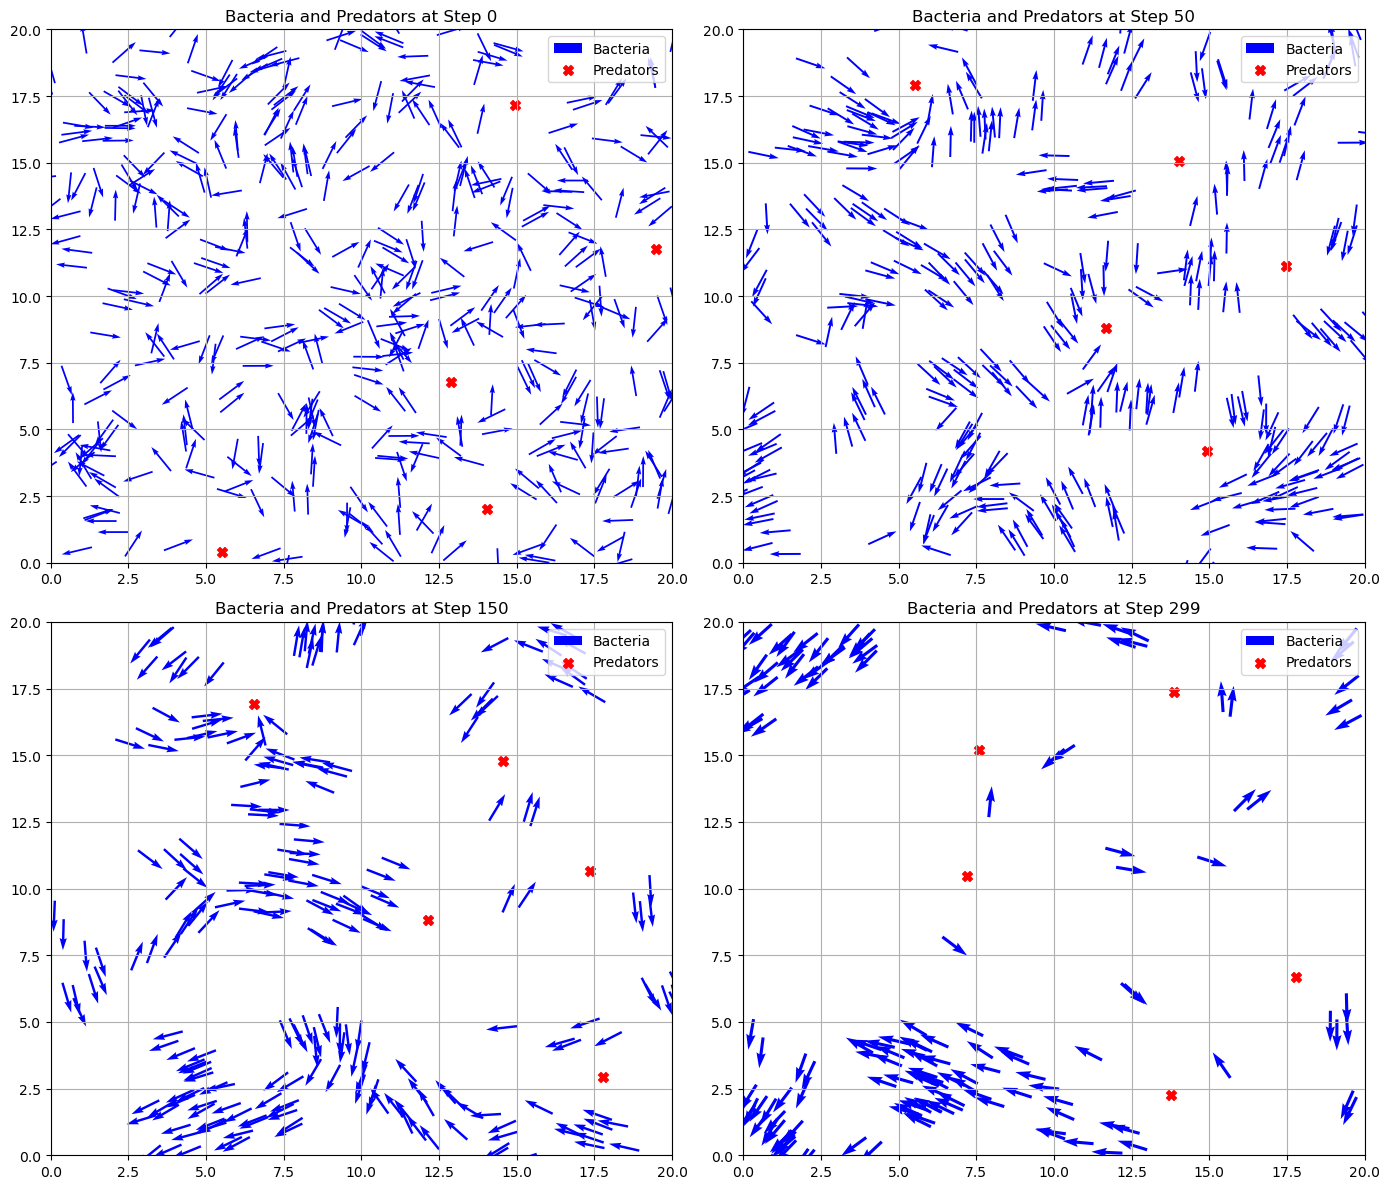

In [22]:
import scipy
import scipy.ndimage

# number of particles
N = 500

# physical space, agent behavior, predator settings, and chemical grid.
L = 20.0
r = 1.0
eta = 0.3
speed = 0.03
time_steps = 300
evasion_radius = 1.5
grid_size = 100
P = 5
pred_speed = 0.05
capture_radius = 1.5
deposit_amount = 1.0
decay_rate = 0.01
chemical_grid = np.zeros((grid_size, grid_size))
diffusion_kernel = np.array([[0.05, 0.1, 0.05],
                             [0.1,  0.4, 0.1],
                             [0.05, 0.1, 0.05]])

###This sets up random positions and headings for bacteria and predators, and an empty chemical field.

positions = np.random.rand(N, 2) * L
headings = np.random.rand(N) * 2.0 * np.pi
alive = np.ones(N, dtype=bool)
pred_positions = np.random.rand(P, 2) * L

# Snapshot storage
snapshot_steps = [0, 50, 150, 299]
bacteria_snapshots = []
chemical_snapshots = []



#Maps floating-point coordinates to grid indices for the chemical field.
def to_grid_coords(pos):
    return np.clip((pos / L * grid_size).astype(int), 0, grid_size - 1)

    

survival_counts = []  ###keeping track of surviving bacteria


#Bacteria update:
#Compute flocking neighbors.
#Add predator avoidance if within range.
#Add noise.

#Chemical interaction:
#Deposit signaling molecules.
#Apply diffusion via convolution.
#Apply decay by scaling the grid.
#Speed modulation based on chemical density (quorum sensing).
#Move bacteria.

#Predator update:
#chase center of mass of nearby bacteria.
#Eliminate bacteria within capture radius.
#Snapshot capture for plotting later.

for t in range(time_steps):
    new_headings = np.copy(headings)

    for i in range(N):
        if not alive[i]:
            continue

        # Flocking behavior
        dx = positions[:, 0] - positions[i, 0]
        dy = positions[:, 1] - positions[i, 1]
        dx = dx - L * np.round(dx / L)
        dy = dy - L * np.round(dy / L)
        dist = np.sqrt(dx*dx + dy*dy)
        neighbors = (dist < r) & alive

        avg_vx = np.mean(np.cos(headings[neighbors]))
        avg_vy = np.mean(np.sin(headings[neighbors]))
        avg_heading = np.arctan2(avg_vy, avg_vx)

        # Predator avoidance
        avoid_heading = None
        for j in range(P):
            pdx = positions[i, 0] - pred_positions[j, 0]
            pdy = positions[i, 1] - pred_positions[j, 1]
            pdx = pdx - L * np.round(pdx / L)
            pdy = pdy - L * np.round(pdy / L)
            pdist = np.sqrt(pdx**2 + pdy**2)
            if pdist < evasion_radius:
                ##gives the angle from the predator to the bacterium 
                #which is the exact direction away from the predator.
                avoid_heading = np.arctan2(pdy, pdx) 
                break

        if avoid_heading is not None:
            # Weighted average of alignment and avoidance
            weight = 0.6
            x = weight * np.cos(avg_heading) + (1 - weight) * np.cos(avoid_heading)
            y = weight * np.sin(avg_heading) + (1 - weight) * np.sin(avoid_heading)
            new_heading = np.arctan2(y, x)
        else:
            new_heading = avg_heading

        # Add noise
        new_heading += (random.random() - 0.5) * eta
        new_headings[i] = new_heading

    # Deposit chemical
    for i in range(N):
        if alive[i]:
            gx, gy = to_grid_coords(positions[i])
            chemical_grid[gx, gy] += deposit_amount

    # Diffuse and decay chemical
    chemical_grid = scipy.ndimage.convolve(chemical_grid, diffusion_kernel, mode='wrap')
    chemical_grid *= (1 - decay_rate)

    # Modulate speed with chemical
    local_chemical = np.zeros(N)
    for i in range(N):
        if alive[i]:
            gx, gy = to_grid_coords(positions[i])
            local_chemical[i] = chemical_grid[gx, gy]

    speed_modulation = np.where(local_chemical > 2.0, 1.0, 0.3)

    # Move bacteria
    headings = new_headings
    vx = speed_modulation * speed * np.cos(headings)
    vy = speed_modulation * speed * np.sin(headings)
    positions[:, 0] += vx
    positions[:, 1] += vy
    positions = apply_periodic_boundary(positions)

    # Move predators
    for j in range(P):
        dx = positions[:, 0] - pred_positions[j, 0]
        dy = positions[:, 1] - pred_positions[j, 1]
        dx = dx - L * np.round(dx / L)
        dy = dy - L * np.round(dy / L)
        dist = np.sqrt(dx*dx + dy*dy)
        nearby_bacteria = (dist < 3*r) & alive

        if np.any(nearby_bacteria):
            com_x = np.mean(positions[nearby_bacteria, 0])
            com_y = np.mean(positions[nearby_bacteria, 1])
            direction = np.array([com_x, com_y]) - pred_positions[j]
            direction = direction - L * np.round(direction / L)
            norm = np.linalg.norm(direction)
            if norm > 0:
                direction /= norm
        else:
            direction = np.random.rand(2) - 0.5
            direction /= np.linalg.norm(direction)

        pred_positions[j] += pred_speed * direction
        pred_positions[j] = apply_periodic_boundary(pred_positions[j])

        # Capture bacteria
        capture_dx = positions[:, 0] - pred_positions[j, 0]
        capture_dy = positions[:, 1] - pred_positions[j, 1]
        capture_dx = capture_dx - L * np.round(capture_dx / L)
        capture_dy = capture_dy - L * np.round(capture_dy / L)
        capture_dist = np.sqrt(capture_dx**2 + capture_dy**2)
        eaten = (capture_dist < capture_radius)
        alive[eaten] = False

    survival_counts.append(np.sum(alive))


    
    if t in snapshot_steps:
        bacteria_snapshots.append((t, positions.copy(), headings.copy(), alive.copy(), pred_positions.copy()))
        chemical_snapshots.append((t, chemical_grid.copy()))

# -- Plot snapshots of final result with evasion --
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (step, pos, head, status, preds) in enumerate(bacteria_snapshots):
    axes[idx].quiver(pos[status, 0], pos[status, 1],
                     np.cos(head[status]), np.sin(head[status]),
                     scale=20, color='blue', label="Bacteria")
    axes[idx].scatter(preds[:, 0], preds[:, 1], color='red', s=50, marker='X', label='Predators')
    axes[idx].set_xlim(0, L)
    axes[idx].set_ylim(0, L)
    axes[idx].set_title(f"Bacteria and Predators at Step {step}")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()



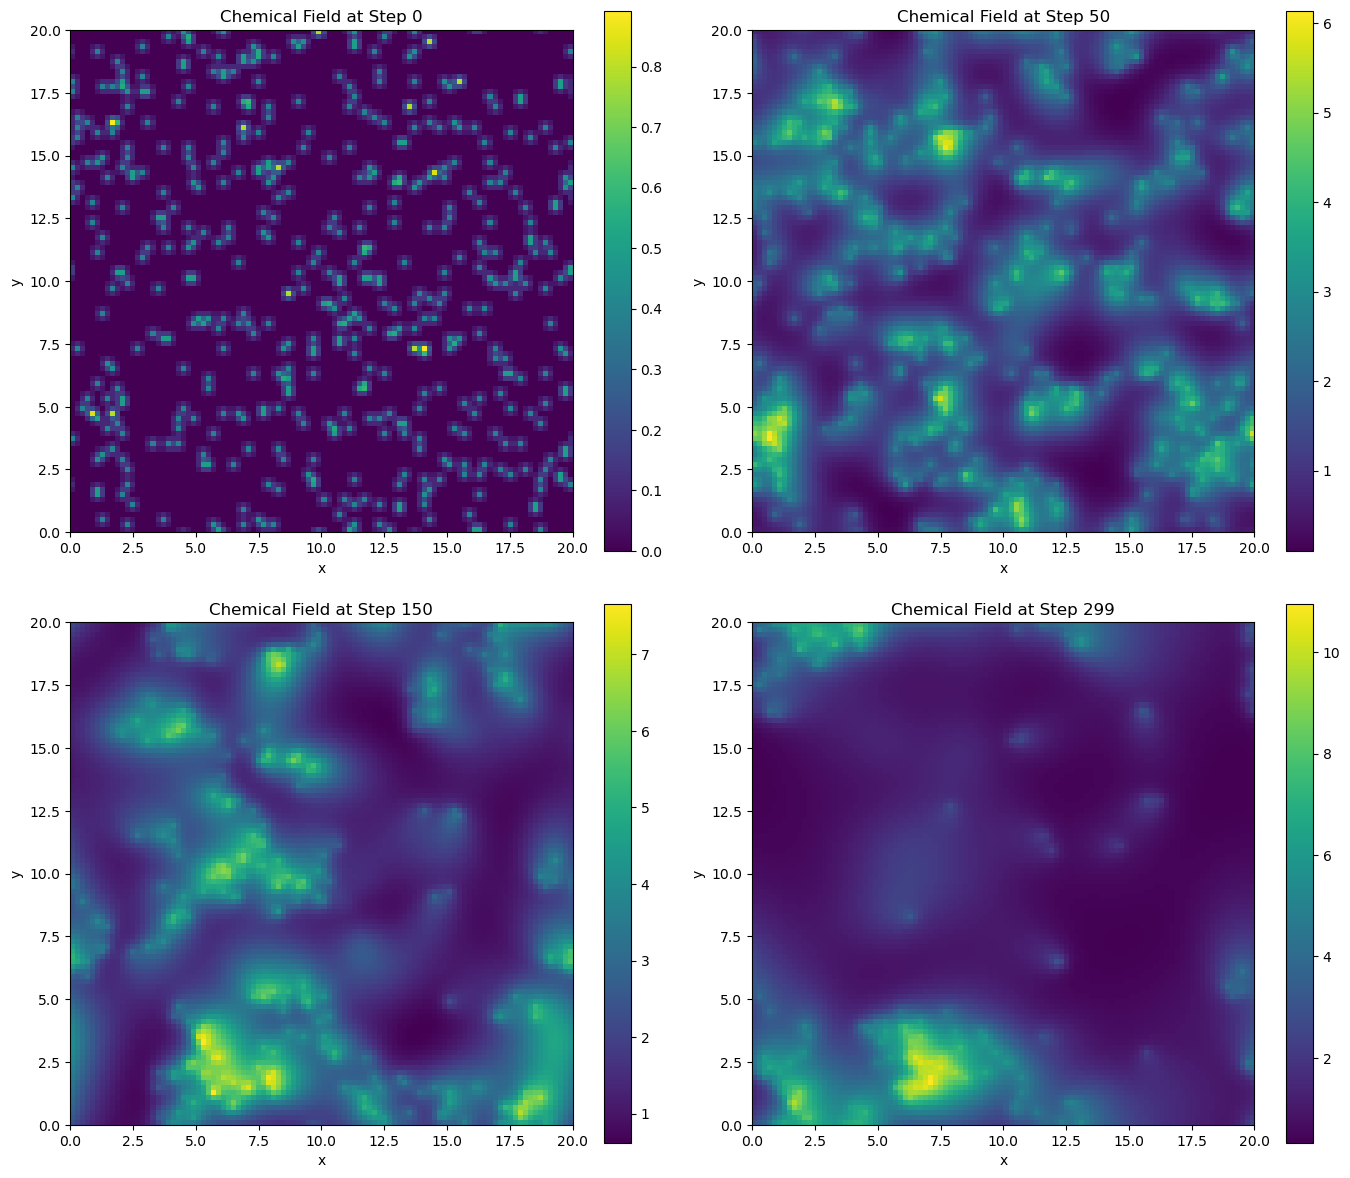

In [23]:
# Plot chemical field snapshots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (step, grid) in enumerate(chemical_snapshots):
    im = axes[idx].imshow(grid.T, origin='lower', cmap='viridis', extent=[0, L, 0, L])
    axes[idx].set_title(f"Chemical Field at Step {step}")
    axes[idx].set_xlabel("x")
    axes[idx].set_ylabel("y")
    fig.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()


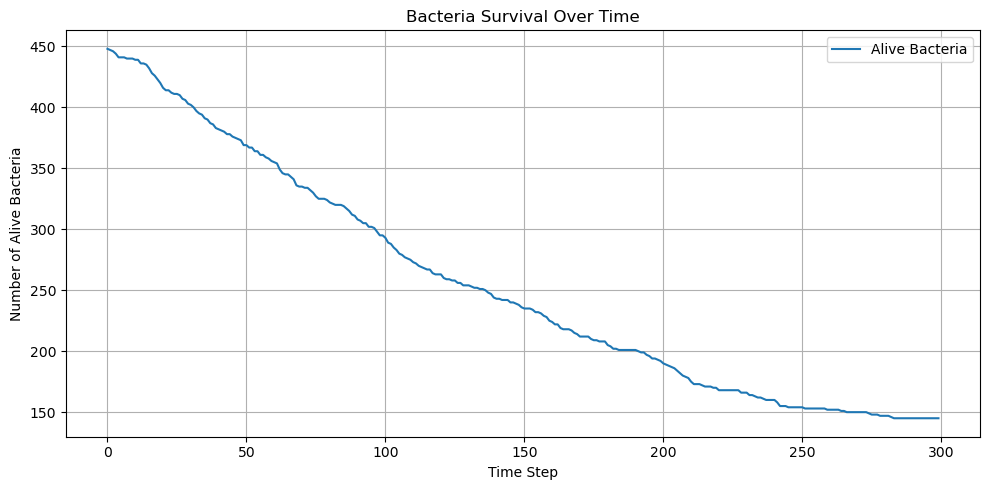

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(survival_counts, label="Alive Bacteria")
plt.xlabel("Time Step")
plt.ylabel("Number of Alive Bacteria")
plt.title("Bacteria Survival Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


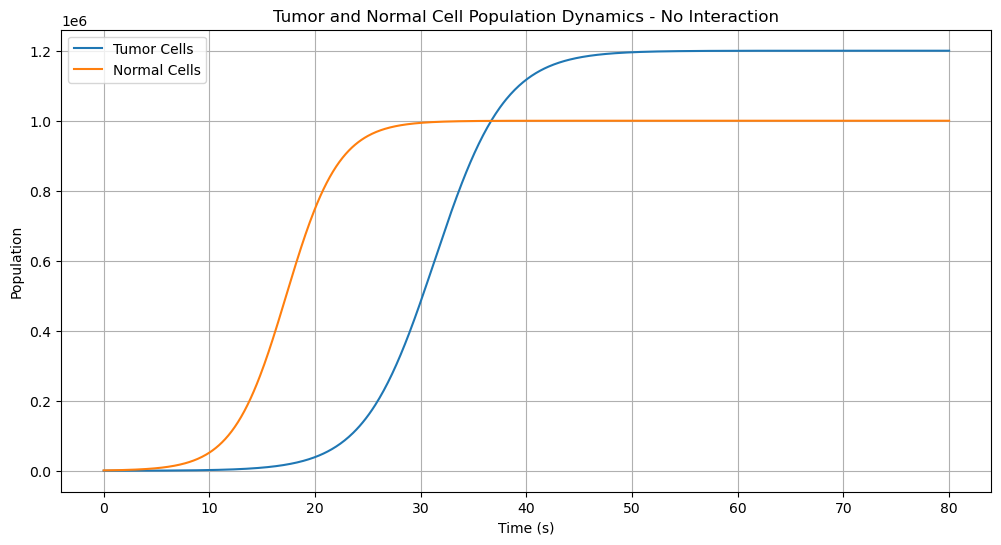

In [25]:
# Witten Core Logistic Model between Tumor and Normal Cells in Immune System

import numpy as np
import matplotlib.pyplot as plt

# Parameters
r_t = 0.3        # Growth rate of tumor cells
r_n = 0.4        # Growth rate of normal cells
K_t = 1.2 * 10**6  # Carrying capacity of tumor cells
K_n = 10**6      # Carrying capacity of normal cells
b = 0            # Tumor-normal cell interaction rate
p0 = 0           # Inhibition strength of tumor growth from normal cells
p1 = 0           # Saturation effect
T1 = 0.1         # Critical number of tumor cells
k = 0            # Tumor-normal cell coupling constant

# Define the ODEs
def tumor(t, T, N):
    return r_t * T * (1 - T / K_t) - b * (p0 * N) / (p1 + N)

def normal(t, T, N):
    return r_n * N * (1 - N / K_n) + k * T * (1 - T / T1)

# Runge-Kutta method
def runge_kutta(T0, N0, t0, t_end, h):
    steps = int((t_end - t0) / h)
    t_values = np.linspace(t0, t_end, steps + 1)
    T_values = np.zeros(steps + 1)
    N_values = np.zeros(steps + 1)
    
    T_values[0] = T0
    N_values[0] = N0

    for i in range(steps):
        t = t_values[i]
        T = T_values[i]
        N = N_values[i]

        # Compute k1, k2, k3, k4 for tumor
        k1_T = tumor(t, T, N)
        k1_N = normal(t, T, N)
        
        k2_T = tumor(t + h / 2, T + h / 2 * k1_T, N + h / 2 * k1_N)
        k2_N = normal(t + h / 2, T + h / 2 * k1_T, N + h / 2 * k1_N)
        
        k3_T = tumor(t + h / 2, T + h / 2 * k2_T, N + h / 2 * k2_N)
        k3_N = normal(t + h / 2, T + h / 2 * k2_T, N + h / 2 * k2_N)
        
        k4_T = tumor(t + h, T + h * k3_T, N + h * k3_N)
        k4_N = normal(t + h, T + h * k3_T, N + h * k3_N)

        T_values[i + 1] = T + h / 6 * (k1_T + 2 * k2_T + 2 * k3_T + k4_T)
        N_values[i + 1] = N + h / 6 * (k1_N + 2 * k2_N + 2 * k3_N + k4_N)

    return t_values, T_values, N_values

# Initial conditions
T0 = 100         # Initial number of tumor cells
N0 = 1000        # Initial number of normal cells
t0 = 0           # Start time
t_end = 80       # End time
h = 0.1          # Time step

# Solve the system
t_values, T_values, N_values = runge_kutta(T0, N0, t0, t_end, h)

# Plot the results
plt.figure(figsize = (12,6))
plt.plot(t_values, T_values, label="Tumor Cells")
plt.plot(t_values, N_values, label="Normal Cells")
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.title('Tumor and Normal Cell Population Dynamics - No Interaction')
plt.grid(True)
plt.savefig("org.png")
plt.show()



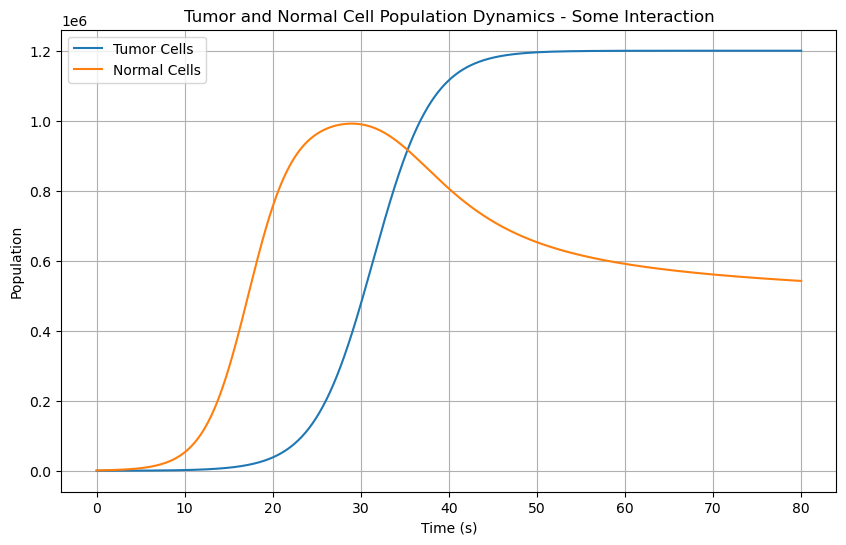

In [26]:
# Witten Core Model with Interaction between Tum

import numpy as np
import matplotlib.pyplot as plt

# Parameters
r_t = 0.3        # Growth rate of tumor cells
r_n = 0.4        # Growth rate of normal cells
K_t = 1.2 * 10**6  # Carrying capacity of tumor cells
K_n = 10**6      # Carrying capacity of normal cells
b = 1            # Tumor-normal cell interaction rate
p0 = 1           # Inhibition strength of tumor growth from normal cells
p1 = 1000           # Saturation effect
T1 = 3*10**5       # Critical number of tumor cells
k = 0.028            # Tumor-normal cell coupling constant

# Define the ODEs
def tumor(t, T, N):
    return r_t * T * (1 - T / K_t) - b * (p0 * N) / (p1 + N)

def normal(t, T, N):
    return r_n * N * (1 - N / K_n) + k * T * (1 - T / T1)

# Runge-Kutta method
def runge_kutta(T0, N0, t0, t_end, h):
    steps = int((t_end - t0) / h)
    t_values = np.linspace(t0, t_end, steps + 1)
    T_values = np.zeros(steps + 1)
    N_values = np.zeros(steps + 1)
    
    T_values[0] = T0
    N_values[0] = N0

    for i in range(steps):
        t = t_values[i]
        T = T_values[i]
        N = N_values[i]

        # Compute k1, k2, k3, k4 for tumor
        k1_T = tumor(t, T, N)
        k1_N = normal(t, T, N)
        
        k2_T = tumor(t + h / 2, T + h / 2 * k1_T, N + h / 2 * k1_N)
        k2_N = normal(t + h / 2, T + h / 2 * k1_T, N + h / 2 * k1_N)
        
        k3_T = tumor(t + h / 2, T + h / 2 * k2_T, N + h / 2 * k2_N)
        k3_N = normal(t + h / 2, T + h / 2 * k2_T, N + h / 2 * k2_N)
        
        k4_T = tumor(t + h, T + h * k3_T, N + h * k3_N)
        k4_N = normal(t + h, T + h * k3_T, N + h * k3_N)

        T_values[i + 1] = T + h / 6 * (k1_T + 2 * k2_T + 2 * k3_T + k4_T)
        N_values[i + 1] = N + h / 6 * (k1_N + 2 * k2_N + 2 * k3_N + k4_N)

    return t_values, T_values, N_values

# Initial conditions
T0 = 100         # Initial number of tumor cells
N0 = 1000        # Initial number of normal cells
t0 = 0           # Start time
t_end = 80       # End time
h = 0.1          # Time step

# Solve the system
t_values, T_values, N_values = runge_kutta(T0, N0, t0, t_end, h)

# Plot the results
plt.figure(figsize = (10,6))
plt.plot(t_values, T_values, label="Tumor Cells")
plt.plot(t_values, N_values, label="Normal Cells")
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.title('Tumor and Normal Cell Population Dynamics - Some Interaction')
plt.grid(True)
plt.savefig("new.png")
plt.show()


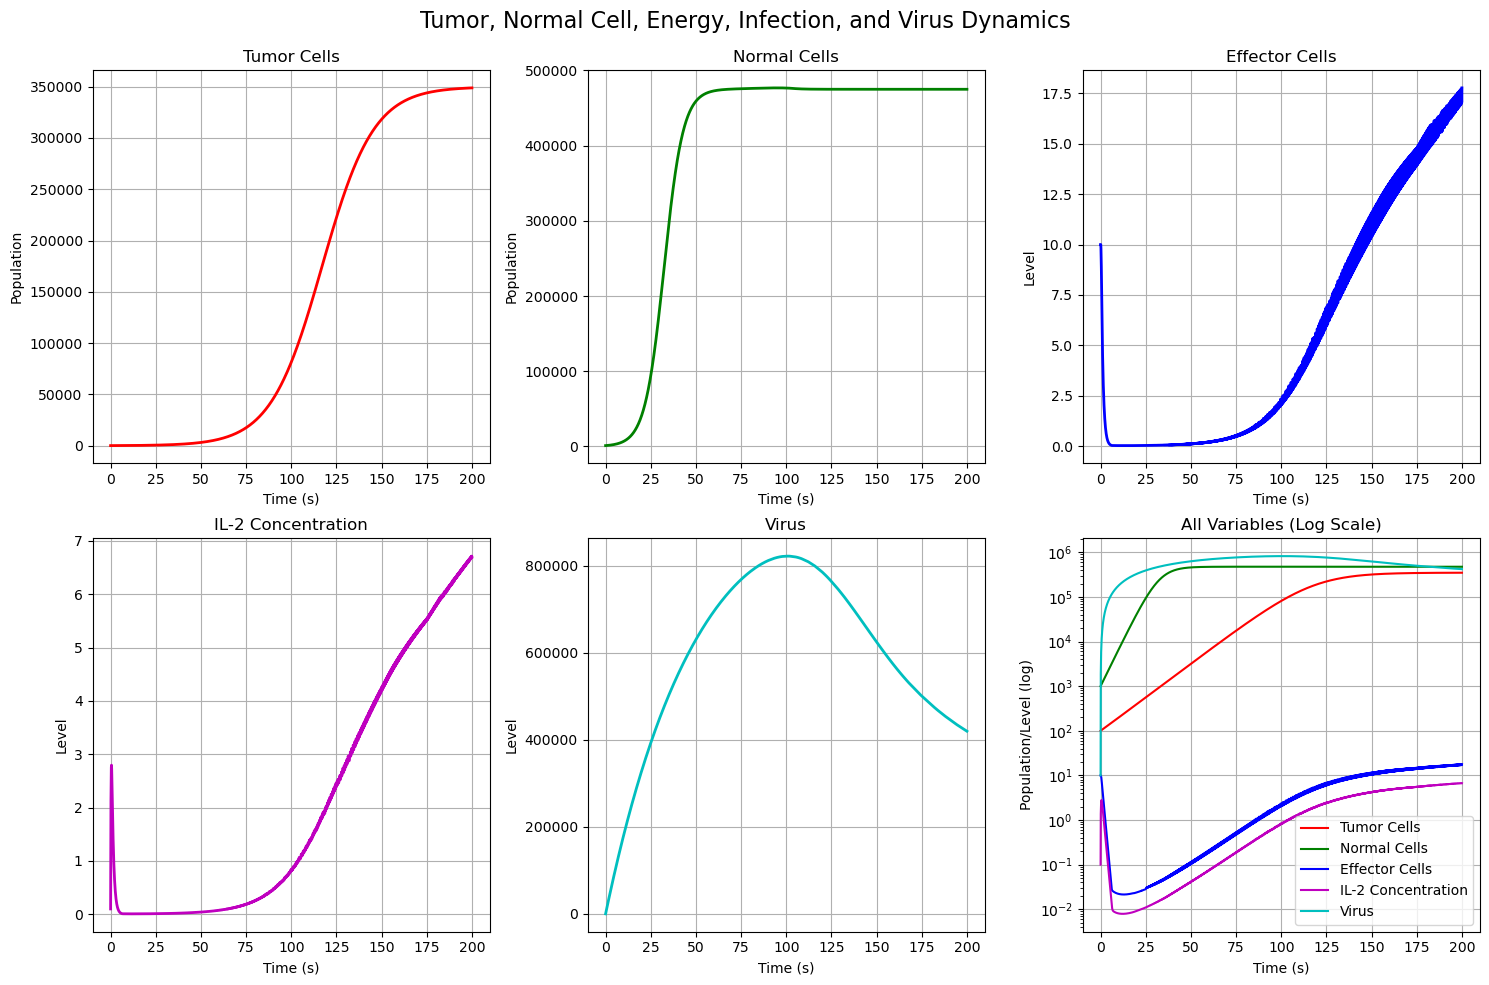

In [27]:
# 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Parameters
r_t = 0.1        # Reduced growth rate of tumor cells
k_t = 5 * 10**5  # Reduced carrying capacity of tumor cells
b = 0.5          # Reduced tumor-normal cell interaction rate
p0 = 0.5         # Reduced inhibition strength of tumor growth from normal cells
p1 = 500         # Reduced saturation effect
a = 0.5          # Reduced tumor interaction rate with energy
g2 = 10**4       # Reduced energy saturation constant for tumor
rN = 0.2         # Reduced growth rate of normal cells
kN = 5 * 10**5   # Reduced carrying capacity of normal cells
k = 0.015        # Reduced tumor-normal cell coupling constant
T1 = 1 * 10**5   # Reduced critical number of tumor cells
c = 0.002        # Reduced energy production constant
u2 = 0.02        # Reduced energy decay rate
g1 = 1 * 10**7   # Adjusted energy saturation constant for infection
p_2 = 2          # Reduced infection rate constant
g3 = 20          # Reduced infection saturation constant
u3 = 5           # Reduced infection decay rate
u1 = 0.02        # Reduced virus decay rate
b1 = 5           # Virus loss due to infection
a1 = 1 * 10**-4  # Virus interaction rate with energy
n = 2 * 10**4    # Reduced virus production constant
y = 0.002        # Reduced virus loss rate due to infection
s = 1            # Tumor suppression by virus (unchanged)
x = 0.03         # Reduced tumor death rate
d = 0.01         # Death rate of normal cells
f = 0.01         # Energy loss due to infection
h = 0            # Additional energy loss factor

# Epsilon for preventing division by zero
eps = 1e-10

# Define the ODEs
def dTdt(t, T, N, E):
    # Prevent division by zero in the denominator
    # Make sure all terms are physically meaningful
    T = max(0, T)  # Ensure T is non-negative
    N = max(0, N)  # Ensure N is non-negative
    E = max(0, E)  # Ensure E is non-negative
    
    growth = r_t * T * (1 - T / k_t) if T <= k_t else 0
    inhibition = b * (p0 * N) / (p1 + N + eps) if N > 0 else 0
    energy_effect = (a * E * T) / (g2 + T) if E > 0 and T > 0 else 0
    death = x * T
    
    dT = growth - inhibition - energy_effect - death
    return max(-T, dT)  # Ensure T doesn't go negative

def dNdt(t, T, N):
    # Ensure values are physically meaningful
    T = max(0, T)
    N = max(0, N)
    
    growth = rN * N * (1 - N / kN) if N <= kN else 0
    coupling = k * T * (1 - T / T1) if T <= T1 else 0
    death = d * N
    
    dN = growth + coupling - death
    return max(-N, dN)  # Ensure N doesn't go negative

def dEdt(t, T, E, I, V):
    # Ensure values are physically meaningful
    T = max(0, T)
    E = max(0, E)
    I = max(0, I)
    V = max(0, V)
    
    production = c * T
    decay = u2 * E
    infection_effect = (p1 * E * I) / (g1 + I + eps) if I > 0 else 0
    virus_effect = a1 * V * E if V > 0 and E > 0 else 0
    energy_loss = f * E
    additional_effect = h * E
    
    dE = production - decay + infection_effect - virus_effect - energy_loss + additional_effect
    return max(-E, dE)  # Ensure E doesn't go negative

def dIdt(t, T, E, I):
    # Ensure values are physically meaningful
    T = max(0, T)
    E = max(0, E)
    I = max(0, I)
    
    infection_rate = (p_2 * T * E) / (g3 + T + eps) if T > 0 and E > 0 else 0
    clearance = u3 * I
    
    dI = infection_rate - clearance
    return max(-I, dI)  # Ensure I doesn't go negative

def dVdt(t, E, V):
    # Ensure values are physically meaningful
    E = max(0, E)
    V = max(0, V)
    
    production = (n * V) / (b1 + V + eps) if V > 0 else 0
    energy_effect = y * V * E if V > 0 and E > 0 else 0
    decay = u1 * V
    
    dV = production - energy_effect - decay
    return max(-V, dV)  # Ensure V doesn't go negative

# Runge-Kutta method with improved stability
def runge_kutta(T0, N0, E0, I0, V0, t0, t_end, h):
    steps = int((t_end - t0) / h)
    t_values = np.linspace(t0, t_end, steps + 1)
    T_values = np.zeros(steps + 1)
    N_values = np.zeros(steps + 1)
    E_values = np.zeros(steps + 1)
    I_values = np.zeros(steps + 1)
    V_values = np.zeros(steps + 1)
    
    # Initial conditions
    T_values[0] = max(0, T0)
    N_values[0] = max(0, N0)
    E_values[0] = max(0, E0)
    I_values[0] = max(0, I0)
    V_values[0] = max(0, V0)

    for i in range(steps):
        t = t_values[i]
        T = T_values[i]
        N = N_values[i]
        E = E_values[i]
        I = I_values[i]
        V = V_values[i]
        
        # Ensure non-negative values before calculating derivatives
        T = max(0, T)
        N = max(0, N)
        E = max(0, E)
        I = max(0, I)
        V = max(0, V)

        # Compute k1
        k1_T = dTdt(t, T, N, E)
        k1_N = dNdt(t, T, N)
        k1_E = dEdt(t, T, E, I, V)
        k1_I = dIdt(t, T, E, I)
        k1_V = dVdt(t, E, V)
        
        # Compute k2
        T2 = max(0, T + h / 2 * k1_T)
        N2 = max(0, N + h / 2 * k1_N)
        E2 = max(0, E + h / 2 * k1_E)
        I2 = max(0, I + h / 2 * k1_I)
        V2 = max(0, V + h / 2 * k1_V)
        
        k2_T = dTdt(t + h / 2, T2, N2, E2)
        k2_N = dNdt(t + h / 2, T2, N2)
        k2_E = dEdt(t + h / 2, T2, E2, I2, V2)
        k2_I = dIdt(t + h / 2, T2, E2, I2)
        k2_V = dVdt(t + h / 2, E2, V2)
        
        # Compute k3
        T3 = max(0, T + h / 2 * k2_T)
        N3 = max(0, N + h / 2 * k2_N)
        E3 = max(0, E + h / 2 * k2_E)
        I3 = max(0, I + h / 2 * k2_I)
        V3 = max(0, V + h / 2 * k2_V)
        
        k3_T = dTdt(t + h / 2, T3, N3, E3)
        k3_N = dNdt(t + h / 2, T3, N3)
        k3_E = dEdt(t + h / 2, T3, E3, I3, V3)
        k3_I = dIdt(t + h / 2, T3, E3, I3)
        k3_V = dVdt(t + h / 2, E3, V3)
        
        # Compute k4
        T4 = max(0, T + h * k3_T)
        N4 = max(0, N + h * k3_N)
        E4 = max(0, E + h * k3_E)
        I4 = max(0, I + h * k3_I)
        V4 = max(0, V + h * k3_V)
        
        k4_T = dTdt(t + h, T4, N4, E4)
        k4_N = dNdt(t + h, T4, N4)
        k4_E = dEdt(t + h, T4, E4, I4, V4)
        k4_I = dIdt(t + h, T4, E4, I4)
        k4_V = dVdt(t + h, E4, V4)

        # Update values
        T_next = T + h / 6 * (k1_T + 2 * k2_T + 2 * k3_T + k4_T)
        N_next = N + h / 6 * (k1_N + 2 * k2_N + 2 * k3_N + k4_N)
        E_next = E + h / 6 * (k1_E + 2 * k2_E + 2 * k3_E + k4_E)
        I_next = I + h / 6 * (k1_I + 2 * k2_I + 2 * k3_I + k4_I)
        V_next = V + h / 6 * (k1_V + 2 * k2_V + 2 * k3_V + k4_V)
        
        # Enforce non-negativity
        T_values[i + 1] = max(0, T_next)
        N_values[i + 1] = max(0, N_next)
        E_values[i + 1] = max(0, E_next)
        I_values[i + 1] = max(0, I_next)
        V_values[i + 1] = max(0, V_next)

    return t_values, T_values, N_values, E_values, I_values, V_values

# Initial conditions
T0 = 100         # Initial number of tumor cells
N0 = 1000        # Initial number of normal cells
E0 = 10          # Initial energy level
I0 = 0.1         # Initial infection level
V0 = 10          # Initial virus level
t0 = 0           # Start time
t_end = 200      # End time
h = 0.1          # Time step

# Solve the system using Runge-Kutta
t_values, T_values, N_values, E_values, I_values, V_values = runge_kutta(T0, N0, E0, I0, V0, t0, t_end, h)

# Create a figure with subplots for better visualization
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=plt.gcf())

# Plot 1: Tumor Cells
ax1 = plt.subplot(gs[0, 0])
ax1.plot(t_values, T_values, 'r-', linewidth=2)
ax1.set_title('Tumor Cells')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Population')
ax1.grid(True)

# Plot 2: Normal Cells
ax2 = plt.subplot(gs[0, 1])
ax2.plot(t_values, N_values, 'g-', linewidth=2)
ax2.set_title('Normal Cells')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Population')
ax2.grid(True)

# Plot 3: Energy
ax3 = plt.subplot(gs[0, 2])
ax3.plot(t_values, E_values, 'b-', linewidth=2)
ax3.set_title('Effector Cells')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Level')
ax3.grid(True)

# Plot 4: Infection
ax4 = plt.subplot(gs[1, 0])
ax4.plot(t_values, I_values, 'm-', linewidth=2)
ax4.set_title('IL-2 Concentration')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Level')
ax4.grid(True)

# Plot 5: Virus
ax5 = plt.subplot(gs[1, 1])
ax5.plot(t_values, V_values, 'c-', linewidth=2)
ax5.set_title('Virus')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Level')
ax5.grid(True)

# Plot 6: All variables on semi-log scale for comparison
ax6 = plt.subplot(gs[1, 2])
ax6.semilogy(t_values, np.maximum(T_values, 1e-10), 'r-', linewidth=1.5, label="Tumor Cells")
ax6.semilogy(t_values, np.maximum(N_values, 1e-10), 'g-', linewidth=1.5, label="Normal Cells")
ax6.semilogy(t_values, np.maximum(E_values, 1e-10), 'b-', linewidth=1.5, label="Effector Cells")
ax6.semilogy(t_values, np.maximum(I_values, 1e-10), 'm-', linewidth=1.5, label="IL-2 Concentration")
ax6.semilogy(t_values, np.maximum(V_values, 1e-10), 'c-', linewidth=1.5, label="Virus")
ax6.set_title('All Variables (Log Scale)')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Population/Level (log)')
ax6.legend(loc='best')
ax6.grid(True)

plt.tight_layout()
plt.suptitle('Tumor, Normal Cell, Energy, Infection, and Virus Dynamics', fontsize=16)
plt.subplots_adjust(top=0.92)

# Save high-resolution figure
plt.savefig('tumor_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()


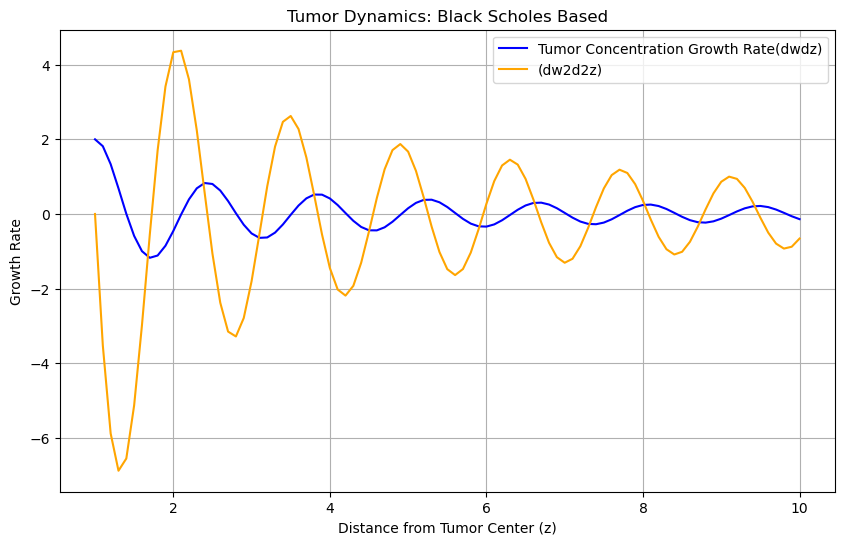

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (adjusted for tumor dynamics)
M = 30  # Rate of tumor proliferation and therapy-dependent killing
L = 1.5  # Diffusion coefficient for GBM (proxy for invasiveness)

# Define the system of ODEs
def system(z, y):
    w, a = y
    dwdz = a
    dadz = (-M * w - 2 * L * a / z) / L
    return np.array([dwdz, dadz])

# Runge-Kutta 4th Order Method
def runge_kutta_4(func, y0, z0, z_end, h):
    steps = int((z_end - z0) / h)
    z_values = np.linspace(z0, z_end, steps + 1)
    y_values = np.zeros((steps + 1, len(y0)))
    y_values[0] = y0

    for i in range(steps):
        z = z_values[i]
        y = y_values[i]
        k1 = h * func(z, y)
        k2 = h * func(z + h/2, y + k1/2)
        k3 = h * func(z + h/2, y + k2/2)
        k4 = h * func(z + h, y + k3)
        y_values[i + 1] = y + (k1 + 2*k2 + 2*k3 + k4) / 6

    return z_values, y_values

# Initial conditions (adjusted for tumor dynamics)
w0 = 2.0  # Higher initial concentration of tumor cells at the origin
a0 = 0.0  # Starting with no initial growth rate at z = 1
y0 = np.array([w0, a0])  # Initial values of w and a
z0 = 1.0  # Starting value of z
z_end = 10.0  # Ending value of z
h = 0.1  # Step size

# Solve the system
z_values, y_values = runge_kutta_4(system, y0, z0, z_end, h)

# Extract w and a
w_values = y_values[:, 0]
a_values = y_values[:, 1]

# Plot the results on the same graph
plt.figure(figsize=(10, 6))
plt.plot(z_values, w_values, label='Tumor Concentration Growth Rate(dwdz)', color='blue')
plt.plot(z_values, a_values, label='(dw2d2z)', color='orange')
plt.title('Tumor Dynamics: Black Scholes Based')
plt.xlabel('Distance from Tumor Center (z)')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.savefig("black-scholes.png")
plt.show()
